In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})


pd.set_option("display.width", 300)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.6f}'.format)

# Load Data

## Load Embeddings

In [2]:
audience_embeddings = pd.read_parquet("NLP Data/Audience Embeddings/rt_audience_embeddings_aggregated.parquet")
critic_embeddings = pd.read_parquet("NLP Data/Critic Embeddings/rt_critic_embeddings_aggregated.parquet")

print(f"Number of movies in audience embeddings data: {audience_embeddings.shape[0]}",
      f"\nNumber of movies in critic embeddings data: {critic_embeddings.shape[0]}")

Number of movies in audience embeddings data: 9116 
Number of movies in critic embeddings data: 9116


## Load Valence Data

In [3]:
audience_valence = pd.read_json("NLP Data/Audience Sentiment Data/rt_audience_valence_aggregated.json")
critic_valence = pd.read_json("NLP Data/Critic Sentiment Data/rt_critic_valence_aggregated.json")

print(f"Number of movies in audience valence data: {audience_valence.shape[0]}",
      f"\nNumber of movies in critic valence data: {critic_valence.shape[0]}")

Number of movies in audience valence data: 9116 
Number of movies in critic valence data: 9116


## Load 'Movies' Data

In [4]:
movies = pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json")

# Merge 'Audience' and 'Critic' Datasets

## Merge 'Audience' and 'Critic' Embeddings

In [5]:
combined_embeddings = pd.merge(left=audience_embeddings.rename(columns={"embeddings": "AudienceEmbeddings"}),
                    right=critic_embeddings.rename(columns={"embeddings": "CriticEmbeddings"}),
                    on="id",
                    how="outer")
combined_embeddings.reset_index(inplace=True)

print(f"Number of rows in combined_embeddings: {combined_embeddings.shape[0]}")
combined_embeddings.head()

Number of rows in combined_embeddings: 9116


,index,id,AudienceEmbeddings,CriticEmbeddings
0,0,10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ..."
1,1,1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ..."
2,2,10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,..."
3,3,10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,..."
4,4,10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -..."


## Merge 'Audience' and 'Critic' Valence Data

In [6]:
combined_valence = pd.merge(left=audience_valence.rename(columns={"AvgValence": "AvgAudienceValence"}),
                            right=critic_valence.rename(columns={"AvgValence": "AvgCriticValence"}),
                             on="id",
                             how="outer")
combined_valence.reset_index(inplace=True)

print(f"Number of rows in combined_valence: {combined_valence.shape[0]}")
combined_valence.head()

Number of rows in combined_valence: 9116


,index,id,AvgAudienceValence,AvgCriticValence
0,0,10000_bc,-0.208172,-0.410251
1,1,1000218-accident,0.534362,0.424794
2,2,10002516-lost_city,0.567837,-0.158982
3,3,10002635-bridge_of_san_luis_rey,-0.028470,-0.647940
4,4,10003276-criminal,0.313468,0.281749


# Calculate Divergence/Similarity Metrics

## Calculate Cosine Similarity

In [7]:
combined_embeddings["CosineSimilarity"] = combined_embeddings.apply(lambda row: cosine_similarity([row["AudienceEmbeddings"]], [row["CriticEmbeddings"]])[0][0], axis=1)
combined_embeddings.head()

,index,id,AudienceEmbeddings,CriticEmbeddings,CosineSimilarity
0,0,10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ...",0.902636
1,1,1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ...",0.901405
2,2,10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,...",0.888783
3,3,10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,...",0.810171
4,4,10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -...",0.898567


## Create Column Containing Difference of Average Audience and Critic Sentiment

In [8]:
combined_valence["ValenceDifference"] = (combined_valence["AvgAudienceValence"] - combined_valence["AvgCriticValence"])
combined_valence["AbsValenceDifference"] = combined_valence["ValenceDifference"].abs()

combined_valence.head()

,index,id,AvgAudienceValence,AvgCriticValence,ValenceDifference,AbsValenceDifference
0,0,10000_bc,-0.208172,-0.410251,0.202079,0.202079
1,1,1000218-accident,0.534362,0.424794,0.109568,0.109568
2,2,10002516-lost_city,0.567837,-0.158982,0.726819,0.726819
3,3,10002635-bridge_of_san_luis_rey,-0.028470,-0.647940,0.619471,0.619471
4,4,10003276-criminal,0.313468,0.281749,0.031719,0.031719


# Compartmentalize by Valence and Content Similarity

## Merge Valence and Embeddings data for Grouping

In [9]:
Val_Con_Total = combined_valence.merge(combined_embeddings, on="id", how="inner")[["id", "AbsValenceDifference", "ValenceDifference", "CosineSimilarity"]]

print(f"Total Rows: {Val_Con_Total.shape[0]}")
Val_Con_Total

Total Rows: 9116


,id,AbsValenceDifference,ValenceDifference,CosineSimilarity
0,10000_bc,0.202079,0.202079,0.902636
1,1000218-accident,0.109568,0.109568,0.901405
2,10002516-lost_city,0.726819,0.726819,0.888783
3,10002635-bridge_of_san_luis_rey,0.619471,0.619471,0.810171
4,10003276-criminal,0.031719,0.031719,0.898567
...,...,...,...,...
9111,zoo,0.309993,-0.309993,0.904870
9112,zookeeper,0.524547,0.524547,0.904950
9113,zoolander,0.221285,0.221285,0.906266
9114,zoolander_2,0.065007,0.065007,0.928039


## Compartmentalise Data into Groups Based on Valence Difference and Review Content Divergence

In [10]:
cutoff = 0.25

# Similar Valence and Similar Review Content
sameVal_sameCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] <= Val_Con_Total["AbsValenceDifference"].quantile(cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

# Similar Valence but Diverging Review Content
sameVal_diffCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] <= Val_Con_Total["AbsValenceDifference"].quantile(cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

# Different Valence but Similar Review Content
diffVal_sameCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] > Val_Con_Total["AbsValenceDifference"].quantile(1-cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

# Different Valence and Diverging Review Content
diffVal_diffCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] > Val_Con_Total["AbsValenceDifference"].quantile(1-cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

# Combine subsets into a single DataFrame to use "hue" functionality
sameVal_sameCon["group"] = "Similar Valence, Similar Content"
sameVal_diffCon["group"] = "Similar Valence, Diverging Content"
diffVal_sameCon["group"] = "Diverging Valence, Similar Content"
diffVal_diffCon["group"] = "Diverging Valence, Diverging Content"

combined = pd.concat([diffVal_sameCon, diffVal_diffCon], ignore_index=True).merge(right=movies, how="left", on="id")

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_2661/487500203.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sameVal_sameCon["group"] = "Similar Valence, Similar Content"
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_2661/487500203.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sameVal_diffCon["group"] = "Similar Valence, Diverging Content"
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_2661/487500203.py:22: SettingWithCopyWarning: 
A value is trying to be se

## Divide 'Diverging Valence' Groups into High Audience, Low Critic and Low Critic and High Audience Valence

In [11]:
# Diverging Valence, Similar Content
combined.loc[(combined["group"] == "Diverging Valence, Similar Content") & (combined["ValenceDifference"] >= 0), "group"] = "Audience Favoured, Similar Content"
combined.loc[(combined["group"] == "Diverging Valence, Similar Content") & (combined["ValenceDifference"] < 0), "group"] = "Critic Favoured, Similar Content"

# Diverging Valence, Diverging Content
combined.loc[(combined["group"] == "Diverging Valence, Diverging Content") & (combined["ValenceDifference"] >= 0), "group"] = "Audience Favoured, Diverging Content"
combined.loc[(combined["group"] == "Diverging Valence, Diverging Content") & (combined["ValenceDifference"] < 0), "group"] = "Critic Favoured, Diverging Content"


# Define consistent color mapping and legend labels
group_order = [
    "Audience Favoured, Similar Content",
    "Critic Favoured, Similar Content",
    "Audience Favoured, Diverging Content",
    "Critic Favoured, Diverging Content",
]

palette = sns.color_palette("tab10", n_colors=4)
group_palette = dict(zip(group_order, palette))

## Group Sizes

In [12]:
print(f"Number of Movies that are Audience Favoured, Similar Content: {combined[combined['group'] == 'Audience Favoured, Similar Content'].shape[0]}",
      f"\nNumber of Movies that are Critic Favoured, Similar Content: {combined[combined['group'] =='Critic Favoured, Similar Content'].shape[0]}",
      f"\nNumber of Movies that are Audience Favoured, Diverging Content: {combined[combined['group'] == 'Audience Favoured, Diverging Content'].shape[0]}",
      f"\nNumber of Movies that are Critic Favoured, Diverging Content: {combined[combined['group'] == 'Critic Favoured, Diverging Content'].shape[0]}")

Number of Movies that are Audience Favoured, Similar Content: 108 
Number of Movies that are Critic Favoured, Similar Content: 76 
Number of Movies that are Audience Favoured, Diverging Content: 727 
Number of Movies that are Critic Favoured, Diverging Content: 212


# Group Characteristics

### Popcorn Meter Distributions

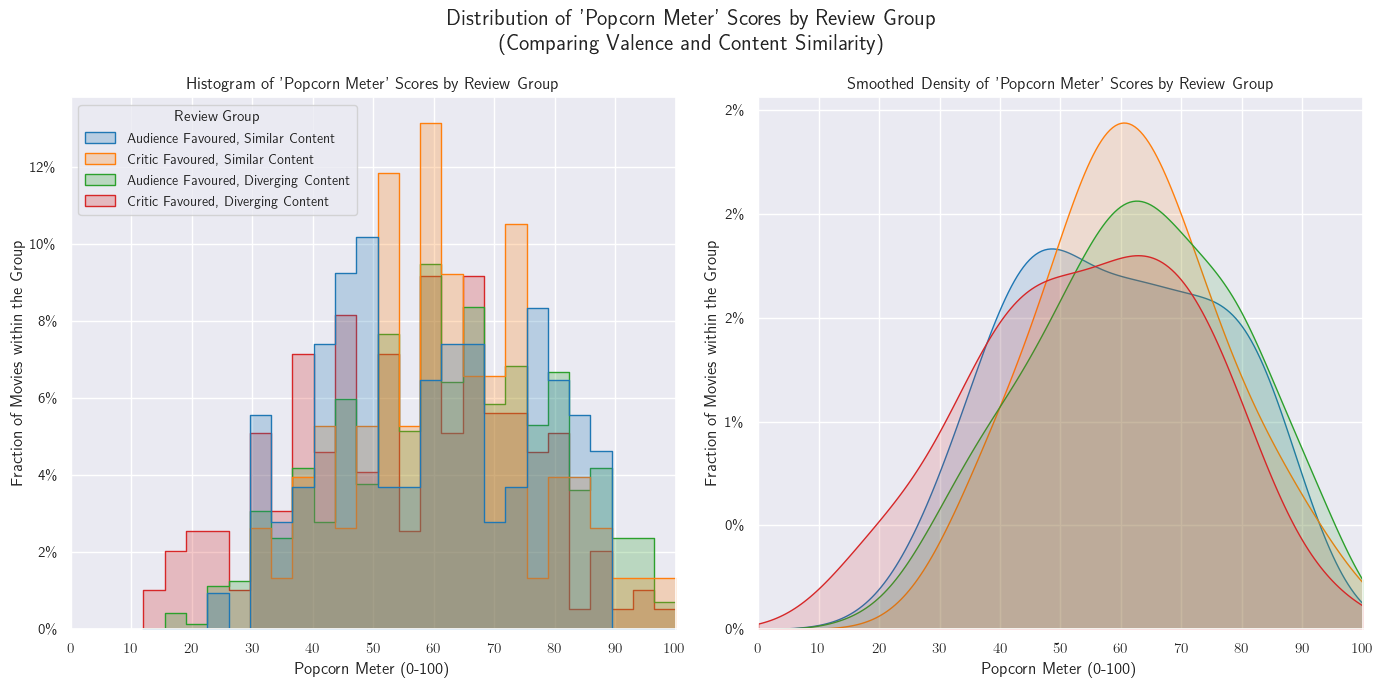

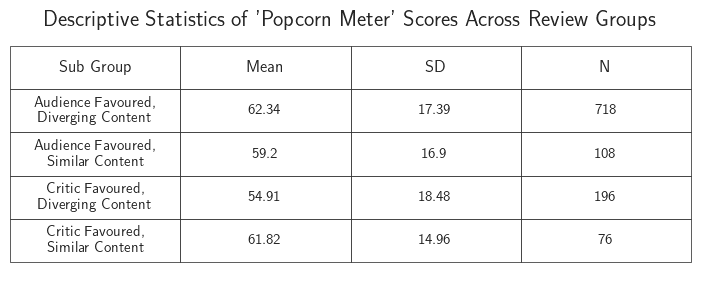

In [13]:
diffVal_data = combined[(combined["group"] == "Audience Favoured, Similar Content") | ((combined["group"] == "Critic Favoured, Similar Content")) | ((combined["group"] == "Audience Favoured, Diverging Content")) | ((combined["group"] == "Critic Favoured, Diverging Content"))]

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Popcorn Meter' Scores by Review Group\n(Comparing Valence and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=diffVal_data, x="audienceScore", hue="group", palette=group_palette, hue_order=group_order, bins=25, element="step", stat="probability", common_norm=False, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Format the automatically created legend
leg = axes[0].get_legend()
leg.set_title("Review Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# KDE
for group in diffVal_data["group"].unique():
    sns.kdeplot(data=diffVal_data[diffVal_data["group"] == group], color=group_palette[group], x="audienceScore", bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Common styling for Plots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Popcorn Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(8,3))
plt.axis("off")
plt.title("Descriptive Statistics of 'Popcorn Meter' Scores Across Review Groups", fontweight="bold", fontsize=16)

# Summary Statistics
summary = diffVal_data.groupby("group").agg(Mean = ("audienceScore", "mean"),
                                        SD = ("audienceScore", "std"),
                                        N = ("audienceScore", "count")).reset_index().round({"Mean": 2, "SD": 2})
summary["group"] = summary["group"].replace({"Audience Favoured, Similar Content": "Audience Favoured,\nSimilar Content",
                                             "Critic Favoured, Similar Content": "Critic Favoured,\nSimilar Content",
                                             "Audience Favoured, Diverging Content": "Audience Favoured,\nDiverging Content",
                                             "Critic Favoured, Diverging Content": "Critic Favoured,\nDiverging Content"})
summary.rename(columns={"group": "Sub Group"}, inplace=True)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")



plt.tight_layout()
plt.show()

#### Test for Normality

In [14]:
# Test  H₀: distribution is normal
#       H₁: distribution is not normal

stat1, p1 = stats.shapiro(combined[combined["group"] == "Audience Favoured, Diverging Content"].dropna(subset=["audienceScore"])["audienceScore"])
stat2, p2 = stats.shapiro(combined[combined["group"] == "Audience Favoured, Similar Content"].dropna(subset=["audienceScore"])["audienceScore"])
stat3, p3 = stats.shapiro(combined[combined["group"] == "Critic Favoured, Diverging Content"].dropna(subset=["audienceScore"])["audienceScore"])
stat4, p4 = stats.shapiro(combined[combined["group"] == "Critic Favoured, Similar Content"].dropna(subset=["audienceScore"])["audienceScore"])

print(f"Shapiro-Wilk test for normality:",
      f"\nAudience Favoured, Diverging Content: {p1:.4f}",
      f"\nAudience Favoured, Similar Content: {p2:.4f}",
      f"\nCritic Favoured, Diverging Content: {p3:.4f}",
      f"\nCritic Favoured, Similar Content: {p4:.4f}")

Shapiro-Wilk test for normality: 
Audience Favoured, Diverging Content: 0.0000 
Audience Favoured, Similar Content: 0.0021 
Critic Favoured, Diverging Content: 0.0728 
Critic Favoured, Similar Content: 0.7339


#### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [15]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [g["audienceScore"].dropna() for _, g in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 23.483, p = 0.0000


#### Pairwise Mann-Whitney U-Tests

In [16]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["audienceScore"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                                Group 1                             Group 2  U-statistic  p-value  p (Bonferroni)  Significant
0  Audience Favoured, Diverging Content  Audience Favoured, Similar Content 42809.000000 0.080746        0.484474        False
1  Audience Favoured, Diverging Content  Critic Favoured, Diverging Content 85737.000000 0.000003        0.000016         True
2  Audience Favoured, Diverging Content    Critic Favoured, Similar Content 28212.500000 0.625438        3.752631        False
3    Audience Favoured, Similar Content  Critic Favoured, Diverging Content 11907.500000 0.071223        0.427340        False
4    Audience Favoured, Similar Content    Critic Favoured, Similar Content  3757.000000 0.329899        1.979391        False
5    Critic Favoured, Diverging Content    Critic Favoured, Similar Content  5960.500000 0.010619        0.063714        False


#### Tomato Meter Distributions

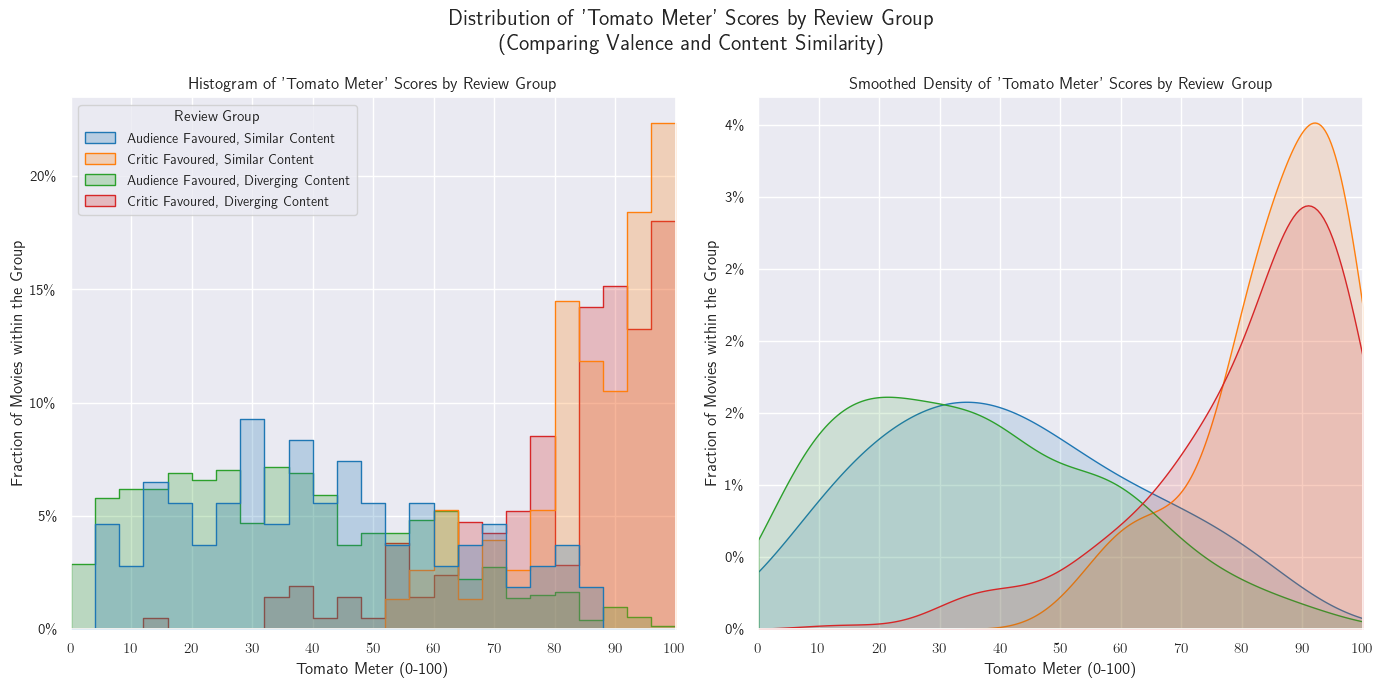

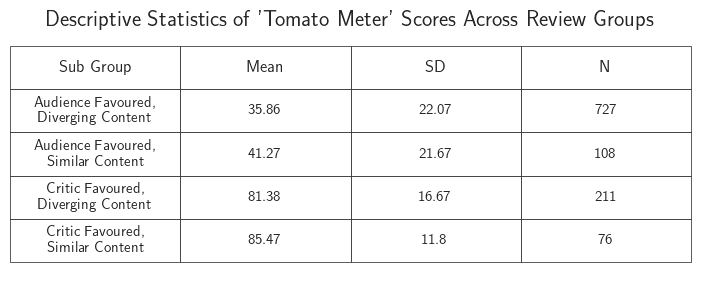

In [17]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Tomato Meter' Scores by Review Group\n(Comparing Valence and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=diffVal_data, x="tomatoMeter", hue="group", palette=group_palette, bins=25, element="step", stat="probability", common_norm=False, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Format the automatically created legend
leg = axes[0].get_legend()
leg.set_title("Review Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# KDE
for group in diffVal_data["group"].unique():
    sns.kdeplot(data=diffVal_data[diffVal_data["group"] == group], color=group_palette[group], x="tomatoMeter", bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Common styling for Plots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Tomato Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(8,3))
plt.axis("off")
plt.title("Descriptive Statistics of 'Tomato Meter' Scores Across Review Groups", fontweight="bold", fontsize=16)

# Summary Statistics
summary = diffVal_data.groupby("group").agg(Mean = ("tomatoMeter", "mean"),
                                        SD = ("tomatoMeter", "std"),
                                        N = ("tomatoMeter", "count")).reset_index().round({"Mean": 2, "SD": 2})
summary["group"] = summary["group"].replace({"Audience Favoured, Similar Content": "Audience Favoured,\nSimilar Content",
                                             "Critic Favoured, Similar Content": "Critic Favoured,\nSimilar Content",
                                             "Audience Favoured, Diverging Content": "Audience Favoured,\nDiverging Content",
                                             "Critic Favoured, Diverging Content": "Critic Favoured,\nDiverging Content"})
summary.rename(columns={"group": "Sub Group"}, inplace=True)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")



plt.tight_layout()
plt.show()

#### Test for Normality

In [18]:
# Test  H₀: distribution is normal
#       H₁: distribution is not normal

stat1, p1 = stats.shapiro(combined[combined["group"] == "Audience Favoured, Diverging Content"].dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat2, p2 = stats.shapiro(combined[combined["group"] == "Audience Favoured, Similar Content"].dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat3, p3 = stats.shapiro(combined[combined["group"] == "Critic Favoured, Diverging Content"].dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat4, p4 = stats.shapiro(combined[combined["group"] == "Critic Favoured, Similar Content"].dropna(subset=["tomatoMeter"])["tomatoMeter"])

print(f"Shapiro-Wilk test for normality:",
      f"\nAudience Favoured, Diverging Content: {p1:.4f}",
      f"\nAudience Favoured, Similar Content: {p2:.4f}",
      f"\nCritic Favoured, Diverging Content: {p3:.4f}",
      f"\nCritic Favoured, Similar Content: {p4:.4f}")

Shapiro-Wilk test for normality: 
Audience Favoured, Diverging Content: 0.0000 
Audience Favoured, Similar Content: 0.0139 
Critic Favoured, Diverging Content: 0.0000 
Critic Favoured, Similar Content: 0.0000


#### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [19]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [g["tomatoMeter"].dropna() for _, g in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 507.354, p = 0.0000


#### Pairwise Mann-Whitney U-Tests

In [20]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["tomatoMeter"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                                Group 1                             Group 2  U-statistic  p-value  p (Bonferroni)  Significant
0  Audience Favoured, Diverging Content  Audience Favoured, Similar Content 33540.500000 0.014497        0.086982        False
1  Audience Favoured, Diverging Content  Critic Favoured, Diverging Content  9690.500000 0.000000        0.000000         True
2  Audience Favoured, Diverging Content    Critic Favoured, Similar Content  1820.000000 0.000000        0.000000         True
3    Audience Favoured, Similar Content  Critic Favoured, Diverging Content  1794.500000 0.000000        0.000000         True
4    Audience Favoured, Similar Content    Critic Favoured, Similar Content   347.500000 0.000000        0.000000         True
5    Critic Favoured, Diverging Content    Critic Favoured, Similar Content  7159.500000 0.166410        0.998461        False


#### Box Office

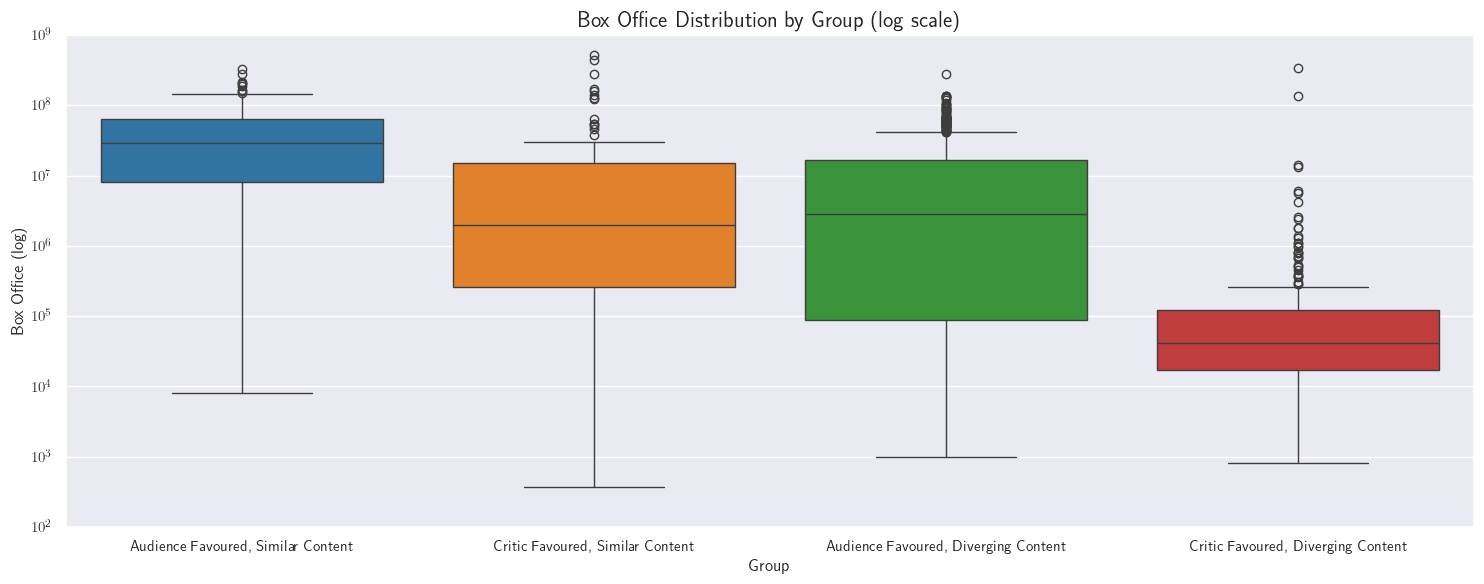

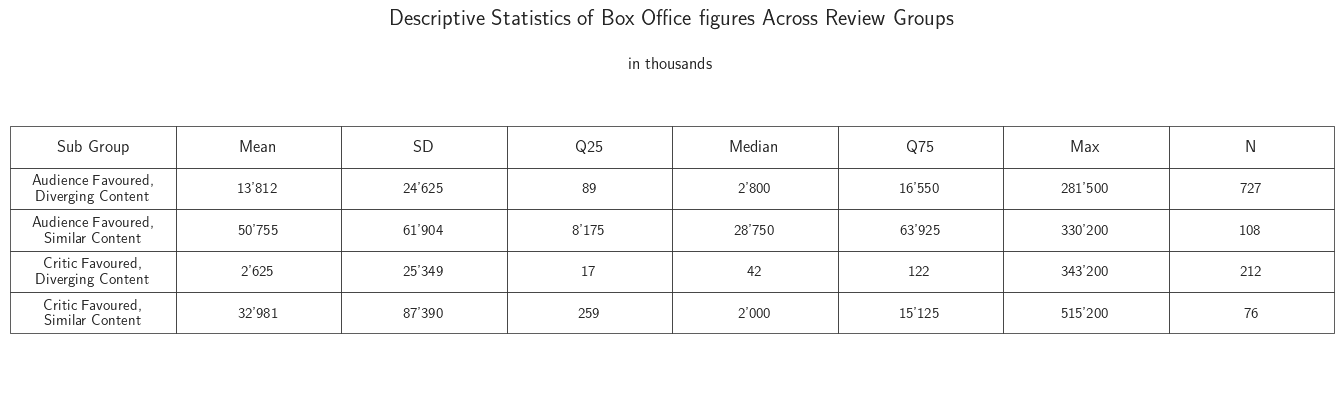

In [21]:
sns.set_theme(style="darkgrid")

# Boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(data=diffVal_data, x="group", y="boxOffice", hue="group", hue_order=group_order, palette=group_palette)
plt.yscale("log")
plt.title("Box Office Distribution by Group (log scale)", fontweight = "bold", fontsize=16)
plt.xlabel("Group")
plt.ylabel("Box Office (log)")
plt.ylim((100, 1000000000))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(15,4))
plt.axis("off")
plt.suptitle("Descriptive Statistics of Box Office figures Across Review Groups", fontweight="bold", fontsize=16)
plt.title("in thousands", fontsize=12)

# Summary Statistics
summary = diffVal_data.groupby("group").agg(Mean = ("boxOffice", "mean"),
                                        SD = ("boxOffice", "std"),
                                        Q25 = ("boxOffice", lambda x: x.quantile(0.25)),
                                        Median = ("boxOffice", lambda x: x.quantile(0.5)),
                                        Q75 = ("boxOffice", lambda x: x.quantile(0.75)),
                                        Max = ("boxOffice", "max"),
                                        N = ("boxOffice", "count")).reset_index().round({"Mean": 2, "SD": 2, "Q25": 2, "Median": 2, "Q75": 2, "Max": 0})

summary["group"] = summary["group"].replace({"Audience Favoured, Similar Content": "Audience Favoured,\nSimilar Content",
                                             "Critic Favoured, Similar Content": "Critic Favoured,\nSimilar Content",
                                             "Audience Favoured, Diverging Content": "Audience Favoured,\nDiverging Content",
                                             "Critic Favoured, Diverging Content": "Critic Favoured,\nDiverging Content"})
summary.rename(columns={"group": "Sub Group"}, inplace=True)

# Format Numbers
def format_k(x):
    """Convert numbers to 'x' K format with apostrophes, e.g., 10'000 K"""
    return f"{x/1000:,.0f}".replace(",", "'")

for col in ["Mean", "SD", "Q25", "Median", "Q75", "Max"]:
    summary[col] = summary[col].apply(format_k)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")

plt.tight_layout()
plt.show()

### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [22]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs
groups = [g["boxOffice"].dropna() for _, g in diffVal_data.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 271.993, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [23]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["boxOffice"].dropna() for name, g in diffVal_data.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                                Group 1                             Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Audience Favoured, Diverging Content  Audience Favoured, Similar Content  19142.000000 0.000000        0.000000         True
1  Audience Favoured, Diverging Content  Critic Favoured, Diverging Content 122825.500000 0.000000        0.000000         True
2  Audience Favoured, Diverging Content    Critic Favoured, Similar Content  26130.000000 0.436995        2.621969        False
3    Audience Favoured, Similar Content  Critic Favoured, Diverging Content  21592.000000 0.000000        0.000000         True
4    Audience Favoured, Similar Content    Critic Favoured, Similar Content   5886.500000 0.000001        0.000003         True
5    Critic Favoured, Diverging Content    Critic Favoured, Similar Content   2339.000000 0.000000        0.000000         True


# Thesis Plots

## Ratings

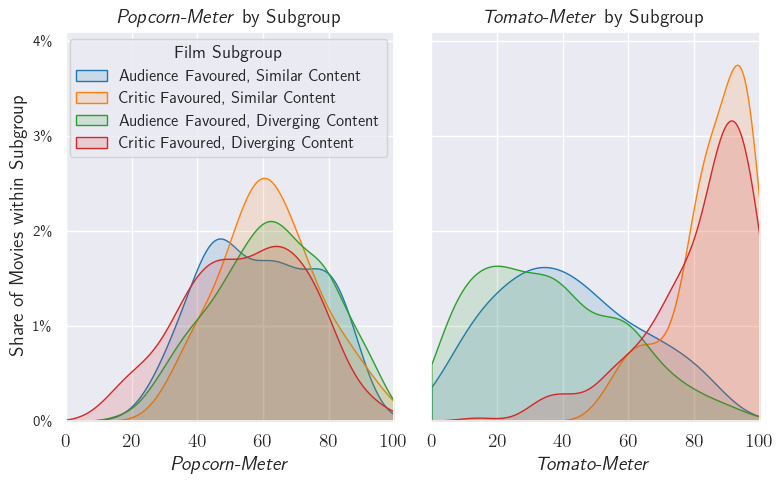

In [50]:
fig, axes = plt.subplots(1,2, figsize=(8,5), sharex=True, sharey=True)
sns.set_theme(style="darkgrid")

# KDE Popcorn Meter
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="audienceScore", color=group_palette[group], bw_adjust=1, clip=(0, 100), ax=axes[0], fill=True, alpha=0.15, label=group)
axes[0].set_title("\emph{Popcorn-Meter} by Subgroup", fontweight="bold", fontsize=14)
axes[0].set_xlabel("\emph{Popcorn-Meter}", fontsize=14)

# KDE Tomato Meter
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="tomatoMeter", color=group_palette[group], bw_adjust=1, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15, label=group)
axes[1].set_title("\emph{Tomato-Meter} by Subgroup", fontweight="bold", fontsize=14)
axes[1].set_xlabel("\emph{Tomato-Meter}", fontsize=14)

# Common styling
for ax in axes:
    ax.set_ylim((0, 0.041))
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks((0, 0.01, 0.02, 0.03, 0.04))
    ax.set_ylabel("Share of Movies within Subgroup", fontsize=14)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))
    ax.tick_params(axis="x", labelsize=14)

# Create & format the legend
leg = axes[0].legend(title="Film Subgroup")
plt.setp(leg.get_title(), fontsize=13, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=12)

plt.tight_layout()
plt.show()

## Box Office

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_2661/2577555768.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


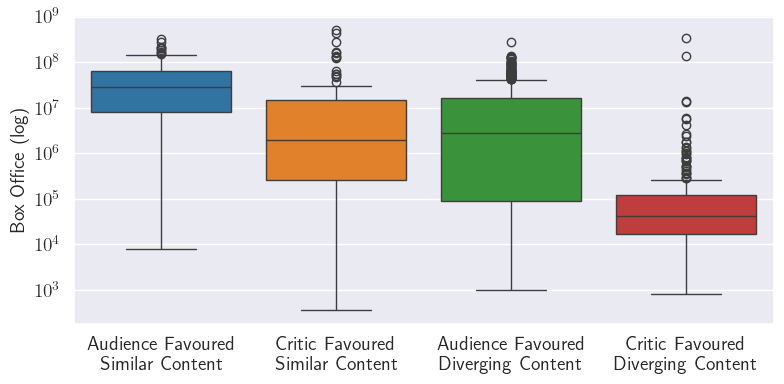

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,4))


# Boxplot
sns.boxplot(data=combined, x="group", y="boxOffice", hue="group", palette=group_palette, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(None)
ax.set_ylabel("Box Office (log)", fontsize=14)

labels = [label.get_text().replace(",", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.tick_params("x", labelsize=14, 
               #labelrotation=30
               )
ax.tick_params("y", labelsize=14)

plt.tight_layout()
plt.show()